# Датасет
[https://www.kaggle.com/c/kkbox-music-recommendation-challenge/overview](https://www.kaggle.com/c/kkbox-music-recommendation-challenge/overview)

Можете мерять результат по 5-fold evaluation на train-set  зer user auc roc.

# Препроцессинг

## Импортируем библиотеки

In [1]:
import time
import pandas as pd
import numpy as np
import copy as c

from tqdm import tqdm
from pathlib import Path

## Загружаем данные

In [2]:
data_path = Path('datasets')
train = pd.read_csv(data_path / 'train.csv', dtype={'msno': 'category',
                                                    'song_id': 'category',
                                                    'source_system_tab': 'category',
                                                    'source_screen_name': 'category',
                                                    'source_type': 'category',
                                                    'target': np.uint8})
test = pd.read_csv(data_path / 'test.csv', dtype={'msno': 'category',
                                                  'song_id': 'category',
                                                  'source_system_tab': 'category',
                                                  'source_screen_name': 'category',
                                                  'source_type': 'category'})
songs = pd.read_csv(data_path / 'songs.csv', dtype={'song_id': 'category',
                                                    'song_length': np.uint8,
                                                    'genre_ids': 'category',
                                                    'artist_name': 'category',
                                                    'composer': 'category',
                                                    'lyricist': 'category',
                                                    'language': 'category'})
song_extra_info = pd.read_csv(data_path / 'song_extra_info.csv')
members = pd.read_csv(data_path / 'members.csv', dtype={'city': 'category',
                                                        'bd': np.uint8,
                                                        'gender': 'category',
                                                        'registered_via': 'category'},
                      parse_dates=['registration_init_time', 'expiration_date'])

In [3]:
train.head(1)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1


In [4]:
test.head(1)

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library


In [5]:
songs.head(1)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,88,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0


In [6]:
song_extra_info.head(1)

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043


In [7]:
members.head(1)

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011-08-20,2017-09-20


## Подготовим `train` к обучению

In [8]:
def per_nan(df):
    for col in df.columns:
        print(f"In column '{col}', the percentage of nans = {100 * df[col].isna().sum() / len(df):.4f}%")

### Подготовим `songs`  к слиянию
Уберем фичи 'composer' и 'lyricist', поскольку для ~85% строк не известны поэты и для ~47% строк неизвестны композиторы.

In [9]:
songs.drop(['composer', 'lyricist'], axis=1, inplace=True)

In [10]:
songs.head(1)

,song_id,song_length,genre_ids,artist_name,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,88,465,張信哲 (Jeff Chang),3.0


### Подготовим `song_extra_info` к слиянию
Извлекаем год и страну из фичи `isrc` в фичи `song_year` и `country` соответственно.

In [11]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        val = int(isrc[5:7])
        if val > 17:
            return 1900 + val
        else:
            return 2000 + val
    else:
        return np.nan

song_extra_info['song_year'] = song_extra_info['isrc'].apply(isrc_to_year)
song_extra_info['country'] = song_extra_info['isrc'].apply(lambda isrc: isrc[:2] if type(isrc) == str else 'unknown')
song_extra_info.drop(['isrc'], axis=1, inplace=True)

In [12]:
song_extra_info.head(1)

,song_id,name,song_year,country
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,2012.0,TW


### Подготовим `members` к слиянию
1. Уберем гендер, поскольку мы часто его не знаем (много пропусков) и  рекомендации в независимости от гендера показали себя лучше;
2. Извлечём в фичи по годам, месяцам, дням из фич `registration_init_time` и `expiration_date`;
3. Пусть если возраст (`bd`) пользователя меньше 10 или больше 70, то у нас нет по нему данных.

In [13]:
per_nan(members)

In column 'msno', the percentage of nans = 0.0000%
In column 'city', the percentage of nans = 0.0000%
In column 'bd', the percentage of nans = 0.0000%
In column 'gender', the percentage of nans = 57.8496%
In column 'registered_via', the percentage of nans = 0.0000%
In column 'registration_init_time', the percentage of nans = 0.0000%
In column 'expiration_date', the percentage of nans = 0.0000%


In [14]:
members.drop(['gender'], axis=1, inplace=True)

In [15]:
members['registration_year'] = members.registration_init_time.apply(lambda x: x.year)
members['registration_month'] = members.registration_init_time.apply(lambda x: x.month)
members['registration_day'] = members.registration_init_time.apply(lambda x: x.day)

members['expiration_year'] = members.expiration_date.apply(lambda x: x.year)
members['expiration_month'] = members.expiration_date.apply(lambda x: x.month)
members['expiration_day'] = members.expiration_date.apply(lambda x: x.day)

members.drop(['registration_init_time', 'expiration_date'], axis=1, inplace=True)

In [16]:
members.loc[(members['bd'] <= 10) | (members['bd'] >= 70), 'bd'] = np.nan

In [17]:
members.head(1)

,msno,city,bd,registered_via,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,NaN,7,2011,8,20,2017,9,20


### Слияние `songs`, `song_extra_info` и `members` с `train`

In [18]:
train = train.merge(songs, on='song_id', how='left')
train = train.merge(song_extra_info, on='song_id', how='left')
train = train.merge(members, on='msno', how='left')

del songs, song_extra_info, members

In [19]:
train.head(1)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,language,...,country,city,bd,registered_via,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,135.0,359,Bastille,52.0,...,GB,1,NaN,7,2012,1,2,2017,10,5


### Разбираемся с пропусками в полученном `train`

In [20]:
def get_not_nan(df, name_col):
    return df[name_col].astype('str').fillna('unknown').astype('category')

In [21]:
per_nan(train)

In column 'msno', the percentage of nans = 0.0000%
In column 'song_id', the percentage of nans = 0.0000%
In column 'source_system_tab', the percentage of nans = 0.3368%
In column 'source_screen_name', the percentage of nans = 5.6226%
In column 'source_type', the percentage of nans = 0.2920%
In column 'target', the percentage of nans = 0.0000%
In column 'song_length', the percentage of nans = 0.0015%
In column 'genre_ids', the percentage of nans = 1.6056%
In column 'artist_name', the percentage of nans = 0.0015%
In column 'language', the percentage of nans = 0.0020%
In column 'name', the percentage of nans = 0.0197%
In column 'song_year', the percentage of nans = 7.8328%
In column 'country', the percentage of nans = 0.0197%
In column 'city', the percentage of nans = 0.0000%
In column 'bd', the percentage of nans = 40.0325%
In column 'registered_via', the percentage of nans = 0.0000%
In column 'registration_year', the percentage of nans = 0.0000%
In column 'registration_month', the perce

1. Пропущенные значения из столбцов `name` и `artist_name` заменим на `unknown`;
2. Опустим строки с неизвестными `language`, `song_length`, поскольку их совсем немного;
3. Остальные пропуски заменяем на наиболее часто встречающиеся.

In [22]:
train['name'] = get_not_nan(train, 'name')
train['artist_name'] = get_not_nan(train, 'artist_name')
train = train[train['song_length'].notna() & train['language'].notna()]
train = train.apply(lambda x: x.fillna(x.value_counts().index[0]))

Проверим, что nan больше нет.

In [23]:
train.isna().sum().sum()

0

# Задача 1
Собрать более-менее приличную рекомендательную систему с помощью GBDT. Использование трюков из лекции (и не из неё), тюнинг и разумных объемов фича инжиниринг прям нужен.

In [24]:
from catboost import cv
from catboost import Pool
from catboost import CatBoostClassifier, CatBoostRegressor

In [25]:
model = CatBoostClassifier(task_type='GPU', loss_function='Logloss', iterations=100)
param_grid = {
    'depth': [5, 10],
    'learning_rate': [0.2, 0.3],
    'l2_leaf_reg': [0.01, 4.0]
}
cat_target = train['target']
cat_train = train.drop(columns=['target'])
cat_features = cat_train.columns.tolist()
cat_features.remove('bd')
cat_features.remove('song_year')
cat_features.remove('song_length')
cat_features.remove('registration_year')
cat_features.remove('registration_month')
cat_features.remove('registration_day')
cat_features.remove('expiration_year')
cat_features.remove('expiration_month')
cat_features.remove('expiration_day')
train_pool = Pool(data=cat_train, label=cat_target, cat_features=cat_features, has_header=True)

In [26]:
gs_result = model.grid_search(param_grid, train_pool)

0:	learn: 0.6719281	test: 0.6710729	best: 0.6710729 (0)	total: 131ms	remaining: 13s
1:	learn: 0.6575099	test: 0.6558937	best: 0.6558937 (1)	total: 255ms	remaining: 12.5s
2:	learn: 0.6451272	test: 0.6436597	best: 0.6436597 (2)	total: 380ms	remaining: 12.3s
3:	learn: 0.6367029	test: 0.6345707	best: 0.6345707 (3)	total: 500ms	remaining: 12s
4:	learn: 0.6301851	test: 0.6276483	best: 0.6276483 (4)	total: 621ms	remaining: 11.8s
5:	learn: 0.6243283	test: 0.6219209	best: 0.6219209 (5)	total: 743ms	remaining: 11.6s
6:	learn: 0.6199859	test: 0.6171463	best: 0.6171463 (6)	total: 861ms	remaining: 11.4s
7:	learn: 0.6166306	test: 0.6135154	best: 0.6135154 (7)	total: 980ms	remaining: 11.3s
8:	learn: 0.6136966	test: 0.6102540	best: 0.6102540 (8)	total: 1.1s	remaining: 11.1s
9:	learn: 0.6109339	test: 0.6076104	best: 0.6076104 (9)	total: 1.21s	remaining: 10.9s
10:	learn: 0.6087903	test: 0.6052582	best: 0.6052582 (10)	total: 1.33s	remaining: 10.8s
11:	learn: 0.6070180	test: 0.6032669	best: 0.6032669 (11)

94:	learn: 0.5866173	test: 0.5812634	best: 0.5812634 (94)	total: 10.7s	remaining: 561ms
95:	learn: 0.5864932	test: 0.5811237	best: 0.5811237 (95)	total: 10.8s	remaining: 449ms
96:	learn: 0.5864917	test: 0.5811199	best: 0.5811199 (96)	total: 10.9s	remaining: 337ms
97:	learn: 0.5864435	test: 0.5810619	best: 0.5810619 (97)	total: 11s	remaining: 225ms
98:	learn: 0.5863680	test: 0.5810028	best: 0.5810028 (98)	total: 11.1s	remaining: 112ms
99:	learn: 0.5863376	test: 0.5809730	best: 0.5809730 (99)	total: 11.2s	remaining: 0us
bestTest = 0.5809730429
bestIteration = 99
0:	loss: 0.5809730	best: 0.5809730 (0)	total: 34.6s	remaining: 4m 2s
0:	learn: 0.6632233	test: 0.6619341	best: 0.6619341 (0)	total: 131ms	remaining: 13s
1:	learn: 0.6443882	test: 0.6432753	best: 0.6432753 (1)	total: 259ms	remaining: 12.7s
2:	learn: 0.6316637	test: 0.6297615	best: 0.6297615 (2)	total: 388ms	remaining: 12.5s
3:	learn: 0.6227709	test: 0.6200938	best: 0.6200938 (3)	total: 509ms	remaining: 12.2s
4:	learn: 0.6173942	te

87:	learn: 0.5854351	test: 0.5799098	best: 0.5799098 (87)	total: 9.83s	remaining: 1.34s
88:	learn: 0.5853004	test: 0.5798597	best: 0.5798597 (88)	total: 9.94s	remaining: 1.23s
89:	learn: 0.5851673	test: 0.5797370	best: 0.5797370 (89)	total: 10.1s	remaining: 1.12s
90:	learn: 0.5851661	test: 0.5797328	best: 0.5797328 (90)	total: 10.2s	remaining: 1s
91:	learn: 0.5851643	test: 0.5797270	best: 0.5797270 (91)	total: 10.3s	remaining: 891ms
92:	learn: 0.5850830	test: 0.5796588	best: 0.5796588 (92)	total: 10.4s	remaining: 781ms
93:	learn: 0.5850452	test: 0.5796107	best: 0.5796107 (93)	total: 10.5s	remaining: 669ms
94:	learn: 0.5850199	test: 0.5795933	best: 0.5795933 (94)	total: 10.6s	remaining: 558ms
95:	learn: 0.5849840	test: 0.5795583	best: 0.5795583 (95)	total: 10.7s	remaining: 446ms
96:	learn: 0.5848990	test: 0.5794713	best: 0.5794713 (96)	total: 10.8s	remaining: 335ms
97:	learn: 0.5848262	test: 0.5793983	best: 0.5793983 (97)	total: 10.9s	remaining: 223ms
98:	learn: 0.5847994	test: 0.579374

81:	learn: 0.5871676	test: 0.5818387	best: 0.5818387 (81)	total: 9.26s	remaining: 2.03s
82:	learn: 0.5869378	test: 0.5816345	best: 0.5816345 (82)	total: 9.38s	remaining: 1.92s
83:	learn: 0.5866850	test: 0.5814144	best: 0.5814144 (83)	total: 9.51s	remaining: 1.81s
84:	learn: 0.5866207	test: 0.5813526	best: 0.5813526 (84)	total: 9.63s	remaining: 1.7s
85:	learn: 0.5865653	test: 0.5812846	best: 0.5812846 (85)	total: 9.74s	remaining: 1.59s
86:	learn: 0.5865309	test: 0.5812274	best: 0.5812274 (86)	total: 9.85s	remaining: 1.47s
87:	learn: 0.5865234	test: 0.5812132	best: 0.5812132 (87)	total: 9.94s	remaining: 1.36s
88:	learn: 0.5864717	test: 0.5811624	best: 0.5811624 (88)	total: 10.1s	remaining: 1.24s
89:	learn: 0.5864674	test: 0.5811517	best: 0.5811517 (89)	total: 10.2s	remaining: 1.13s
90:	learn: 0.5863155	test: 0.5809959	best: 0.5809959 (90)	total: 10.3s	remaining: 1.02s
91:	learn: 0.5862473	test: 0.5809167	best: 0.5809167 (91)	total: 10.4s	remaining: 904ms
92:	learn: 0.5862017	test: 0.5808

74:	learn: 0.5854436	test: 0.5799736	best: 0.5799736 (74)	total: 8.44s	remaining: 2.81s
75:	learn: 0.5854028	test: 0.5799341	best: 0.5799341 (75)	total: 8.55s	remaining: 2.7s
76:	learn: 0.5853735	test: 0.5798902	best: 0.5798902 (76)	total: 8.66s	remaining: 2.59s
77:	learn: 0.5853443	test: 0.5798669	best: 0.5798669 (77)	total: 8.78s	remaining: 2.48s
78:	learn: 0.5853441	test: 0.5798670	best: 0.5798669 (77)	total: 8.86s	remaining: 2.36s
79:	learn: 0.5853347	test: 0.5798457	best: 0.5798457 (79)	total: 8.97s	remaining: 2.24s
80:	learn: 0.5853346	test: 0.5798458	best: 0.5798457 (79)	total: 9.06s	remaining: 2.13s
81:	learn: 0.5853345	test: 0.5798464	best: 0.5798457 (79)	total: 9.14s	remaining: 2.01s
82:	learn: 0.5852997	test: 0.5798037	best: 0.5798037 (82)	total: 9.26s	remaining: 1.9s
83:	learn: 0.5852953	test: 0.5797928	best: 0.5797928 (83)	total: 9.37s	remaining: 1.78s
84:	learn: 0.5851916	test: 0.5797608	best: 0.5797608 (84)	total: 9.48s	remaining: 1.67s
85:	learn: 0.5851672	test: 0.57972

68:	learn: 0.5874039	test: 0.5822446	best: 0.5822446 (68)	total: 15s	remaining: 6.73s
69:	learn: 0.5873459	test: 0.5821504	best: 0.5821504 (69)	total: 15.1s	remaining: 6.47s
70:	learn: 0.5872630	test: 0.5820675	best: 0.5820675 (70)	total: 15.4s	remaining: 6.3s
71:	learn: 0.5872597	test: 0.5820580	best: 0.5820580 (71)	total: 15.5s	remaining: 6.03s
72:	learn: 0.5872181	test: 0.5819926	best: 0.5819926 (72)	total: 15.6s	remaining: 5.78s
73:	learn: 0.5872034	test: 0.5819691	best: 0.5819691 (73)	total: 15.7s	remaining: 5.52s
74:	learn: 0.5871992	test: 0.5819539	best: 0.5819539 (74)	total: 15.8s	remaining: 5.27s
75:	learn: 0.5871667	test: 0.5819100	best: 0.5819100 (75)	total: 15.9s	remaining: 5.02s
76:	learn: 0.5870919	test: 0.5818172	best: 0.5818172 (76)	total: 16s	remaining: 4.79s
77:	learn: 0.5870157	test: 0.5817448	best: 0.5817448 (77)	total: 16.2s	remaining: 4.57s
78:	learn: 0.5870125	test: 0.5817337	best: 0.5817337 (78)	total: 16.3s	remaining: 4.34s
79:	learn: 0.5869250	test: 0.5816652	

62:	learn: 0.5859764	test: 0.5805761	best: 0.5805761 (62)	total: 11.7s	remaining: 6.85s
63:	learn: 0.5859762	test: 0.5805761	best: 0.5805761 (62)	total: 11.7s	remaining: 6.61s
64:	learn: 0.5859762	test: 0.5805762	best: 0.5805761 (62)	total: 11.8s	remaining: 6.37s
65:	learn: 0.5858678	test: 0.5804749	best: 0.5804749 (65)	total: 12s	remaining: 6.19s
66:	learn: 0.5858191	test: 0.5804265	best: 0.5804265 (66)	total: 12.1s	remaining: 5.98s
67:	learn: 0.5857489	test: 0.5803271	best: 0.5803271 (67)	total: 12.3s	remaining: 5.78s
68:	learn: 0.5857488	test: 0.5803232	best: 0.5803232 (68)	total: 12.4s	remaining: 5.56s
69:	learn: 0.5856993	test: 0.5802742	best: 0.5802742 (69)	total: 12.5s	remaining: 5.36s
70:	learn: 0.5856992	test: 0.5802722	best: 0.5802722 (70)	total: 12.6s	remaining: 5.14s
71:	learn: 0.5856966	test: 0.5802639	best: 0.5802639 (71)	total: 12.7s	remaining: 4.93s
72:	learn: 0.5856359	test: 0.5801874	best: 0.5801874 (72)	total: 12.8s	remaining: 4.75s
73:	learn: 0.5855773	test: 0.58014

55:	learn: 0.5887269	test: 0.5837460	best: 0.5837460 (55)	total: 12.8s	remaining: 10s
56:	learn: 0.5885207	test: 0.5835453	best: 0.5835453 (56)	total: 13s	remaining: 9.81s
57:	learn: 0.5884739	test: 0.5834837	best: 0.5834837 (57)	total: 13.1s	remaining: 9.49s
58:	learn: 0.5883397	test: 0.5833382	best: 0.5833382 (58)	total: 13.3s	remaining: 9.23s
59:	learn: 0.5883058	test: 0.5832811	best: 0.5832811 (59)	total: 13.4s	remaining: 8.92s
60:	learn: 0.5881734	test: 0.5831264	best: 0.5831264 (60)	total: 13.6s	remaining: 8.67s
61:	learn: 0.5880137	test: 0.5829840	best: 0.5829840 (61)	total: 13.9s	remaining: 8.51s
62:	learn: 0.5879761	test: 0.5829163	best: 0.5829163 (62)	total: 14s	remaining: 8.23s
63:	learn: 0.5877286	test: 0.5826427	best: 0.5826427 (63)	total: 14.3s	remaining: 8.06s
64:	learn: 0.5876429	test: 0.5825615	best: 0.5825615 (64)	total: 14.6s	remaining: 7.89s
65:	learn: 0.5875710	test: 0.5824823	best: 0.5824823 (65)	total: 15.1s	remaining: 7.79s
66:	learn: 0.5875056	test: 0.5824148	b

49:	learn: 0.5873875	test: 0.5820414	best: 0.5820414 (49)	total: 11.8s	remaining: 11.8s
50:	learn: 0.5873414	test: 0.5819527	best: 0.5819527 (50)	total: 11.9s	remaining: 11.4s
51:	learn: 0.5872150	test: 0.5818306	best: 0.5818306 (51)	total: 12s	remaining: 11.1s
52:	learn: 0.5871261	test: 0.5817192	best: 0.5817192 (52)	total: 12.2s	remaining: 10.8s
53:	learn: 0.5870196	test: 0.5815960	best: 0.5815960 (53)	total: 12.4s	remaining: 10.5s
54:	learn: 0.5869558	test: 0.5815202	best: 0.5815202 (54)	total: 12.5s	remaining: 10.2s
55:	learn: 0.5869542	test: 0.5815126	best: 0.5815126 (55)	total: 12.6s	remaining: 9.91s
56:	learn: 0.5866853	test: 0.5812251	best: 0.5812251 (56)	total: 12.8s	remaining: 9.69s
57:	learn: 0.5866638	test: 0.5811995	best: 0.5811995 (57)	total: 12.9s	remaining: 9.38s
58:	learn: 0.5866388	test: 0.5811757	best: 0.5811757 (58)	total: 13.1s	remaining: 9.09s
59:	learn: 0.5865989	test: 0.5811106	best: 0.5811106 (59)	total: 13.2s	remaining: 8.81s
60:	learn: 0.5863216	test: 0.58089

39:	learn: 0.5895088	test: 0.5839461	best: 0.5839461 (39)	total: 38m 37s	remaining: 57m 55s
40:	learn: 0.5894268	test: 0.5838428	best: 0.5838428 (40)	total: 39m 34s	remaining: 56m 57s
41:	learn: 0.5892650	test: 0.5836516	best: 0.5836516 (41)	total: 40m 32s	remaining: 55m 59s
42:	learn: 0.5891666	test: 0.5835447	best: 0.5835447 (42)	total: 41m 30s	remaining: 55m 1s
43:	learn: 0.5890314	test: 0.5833957	best: 0.5833957 (43)	total: 42m 28s	remaining: 54m 3s
44:	learn: 0.5889196	test: 0.5832620	best: 0.5832620 (44)	total: 43m 27s	remaining: 53m 6s
45:	learn: 0.5888274	test: 0.5831456	best: 0.5831456 (45)	total: 44m 27s	remaining: 52m 10s
46:	learn: 0.5886777	test: 0.5829937	best: 0.5829937 (46)	total: 45m 27s	remaining: 51m 15s
47:	learn: 0.5885946	test: 0.5828956	best: 0.5828956 (47)	total: 46m 27s	remaining: 50m 20s
48:	learn: 0.5883297	test: 0.5826435	best: 0.5826435 (48)	total: 47m 28s	remaining: 49m 24s
49:	learn: 0.5882387	test: 0.5825413	best: 0.5825413 (49)	total: 48m 27s	remaining:

In [27]:
best_params = gs_result['params']
best_params

{'depth': 10, 'learning_rate': 0.3, 'l2_leaf_reg': 4.0}

In [ ]:
#best_params = {'depth': 10, 'learning_rate': 0.3, 'l2_leaf_reg': 4.0}
#best_params

In [30]:
best_params.update({
    'task_type' : 'GPU',
    'loss_function': 'Logloss',
    'iterations': 50,
    'custom_loss': 'AUC'
})

In [31]:
scores = cv(train_pool, best_params, fold_count=5)

0:	learn: 0.6622606	test: 0.6607769	best: 0.6607769 (0)	total: 1m 51s	remaining: 1h 30m 57s
1:	learn: 0.6434666	test: 0.6420201	best: 0.6420201 (1)	total: 3m 43s	remaining: 1h 29m 14s
2:	learn: 0.6307082	test: 0.6284197	best: 0.6284197 (2)	total: 5m 34s	remaining: 1h 27m 26s
3:	learn: 0.6219737	test: 0.6190159	best: 0.6190159 (3)	total: 7m 26s	remaining: 1h 25m 33s
4:	learn: 0.6167744	test: 0.6133953	best: 0.6133953 (4)	total: 9m 17s	remaining: 1h 23m 41s
5:	learn: 0.6123128	test: 0.6088895	best: 0.6088895 (5)	total: 11m 8s	remaining: 1h 21m 45s
6:	learn: 0.6084620	test: 0.6048684	best: 0.6048684 (6)	total: 12m 59s	remaining: 1h 19m 50s
7:	learn: 0.6065882	test: 0.6027379	best: 0.6027379 (7)	total: 14m 50s	remaining: 1h 17m 54s
8:	learn: 0.6048674	test: 0.6007717	best: 0.6007717 (8)	total: 16m 40s	remaining: 1h 15m 58s
9:	learn: 0.6030186	test: 0.5987328	best: 0.5987328 (9)	total: 18m 29s	remaining: 1h 13m 59s
10:	learn: 0.6012868	test: 0.5971086	best: 0.5971086 (10)	total: 20m 18s	rem

In [32]:
print(f"ROC AUC={scores.iloc[-1]['test-AUC-mean']:.5f}+/-{scores.iloc[-1]['test-AUC-std']:.6f}")

ROC AUC=0.75931+/-0.000691


In [36]:
#model.save_model('model.cbm')

In [39]:
#model.save_model('model.py', format='python', pool=train_pool)

In [40]:
#train.to_csv('custom_train.csv')

In [43]:
import shap
shap.initjs()

In [45]:
explainer = shap.TreeExplainer(model)

In [48]:
shap_values = explainer.shap_values(cat_train)

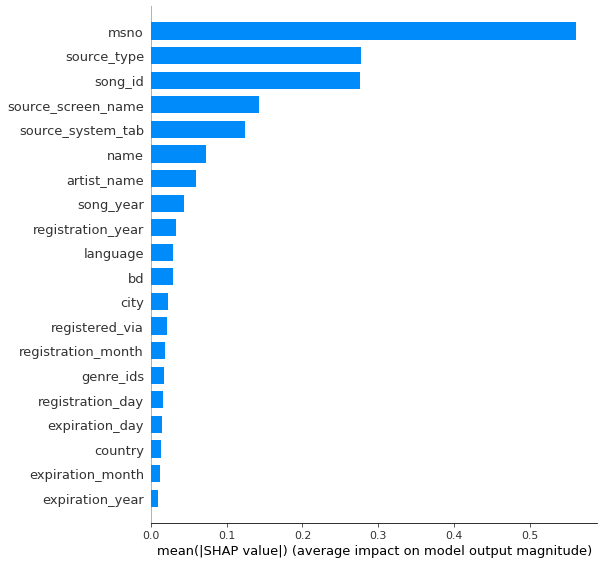

In [50]:
shap.summary_plot(shap_values, cat_train, plot_type="bar")